##Objective:
This is a experimentary Time Series Analysis and Forecasting project in my learning mission. Here I use [superstore sales data](https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls) from tableau community and take guide from some Amizing resources: [1](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775), [2](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b), [3](https://people.duke.edu/~rnau/411home.htm), [4](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3). The objective is applying ARIMA & Prophet Model to forecast total sales for the months and learning better through Experience. Here I use google colab & drive to access data and perform all the analysis. Let's start...

##Data cleaning

In [87]:
#connecting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
%matplotlib inline

In [89]:
DataPath = "/content/drive/My Drive/1DS&Project/superstore_sales_forecasting/ SuperstoreSalesData.xls"
data = pd.read_excel(DataPath)

In [90]:
data.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [91]:
print(data.Category.unique())

['Furniture' 'Office Supplies' 'Technology']


**Here we got that there is 3 category product. we will just work on forecasting only for 'Furniture'.**

In [92]:
furniture = data.loc[data['Category'] == 'Furniture'].copy() #take only Furniture data

In [93]:
furniture['Order Date'].describe()

count                    2121
unique                    889
top       2016-09-05 00:00:00
freq                       10
first     2014-01-06 00:00:00
last      2017-12-30 00:00:00
Name: Order Date, dtype: object

In [94]:
furniture.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 9990
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         2121 non-null   int64         
 1   Order ID       2121 non-null   object        
 2   Order Date     2121 non-null   datetime64[ns]
 3   Ship Date      2121 non-null   datetime64[ns]
 4   Ship Mode      2121 non-null   object        
 5   Customer ID    2121 non-null   object        
 6   Customer Name  2121 non-null   object        
 7   Segment        2121 non-null   object        
 8   Country        2121 non-null   object        
 9   City           2121 non-null   object        
 10  State          2121 non-null   object        
 11  Postal Code    2121 non-null   int64         
 12  Region         2121 non-null   object        
 13  Product ID     2121 non-null   object        
 14  Category       2121 non-null   object        
 15  Sub-Category   2121 n

**Here data shows that there is no null value in any features which is pretty good but uncommon for a dataset we generally found. However, let's move on. In dataset for 2121 entries there is 889 unique days(with different customerId, productId etc.) we have from january 2014 to December 2017. As we need to forecast total sales for the months we need to group sales by the Order Date and calculate total sales for all months**

In [95]:
#removing columns those are not needed in this analysis
#finally we will just have Order Date and sales columns there
drop_cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(drop_cols, axis=1, inplace=True)

In [96]:
furniture.sort_values('Order Date')
furniture.head()

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840


In [97]:
furniture = furniture.groupby(['Order Date'])['Sales'].sum().reset_index().set_index('Order Date')

In [98]:
furniture_msum = furniture.Sales.resample('MS').sum()

In [99]:
furniture_msum.shape

(48,)

In [100]:
print(furniture_msum.shape) #After resapling we just have 48 entries only for 48 months in 4 years data
furniture_avg['2016':'2016'] #each entry consists the total sales of the month of the year

(48,)


Order Date
2016-01-01     7622.7430
2016-02-01     3925.5510
2016-03-01    12801.0920
2016-04-01    13212.0900
2016-05-01    15119.8350
2016-06-01    13070.5720
2016-07-01    13068.5190
2016-08-01    12483.2323
2016-09-01    27262.8809
2016-10-01    11872.5770
2016-11-01    31783.6288
2016-12-01    36678.7150
Freq: MS, Name: Sales, dtype: float64

##EDA

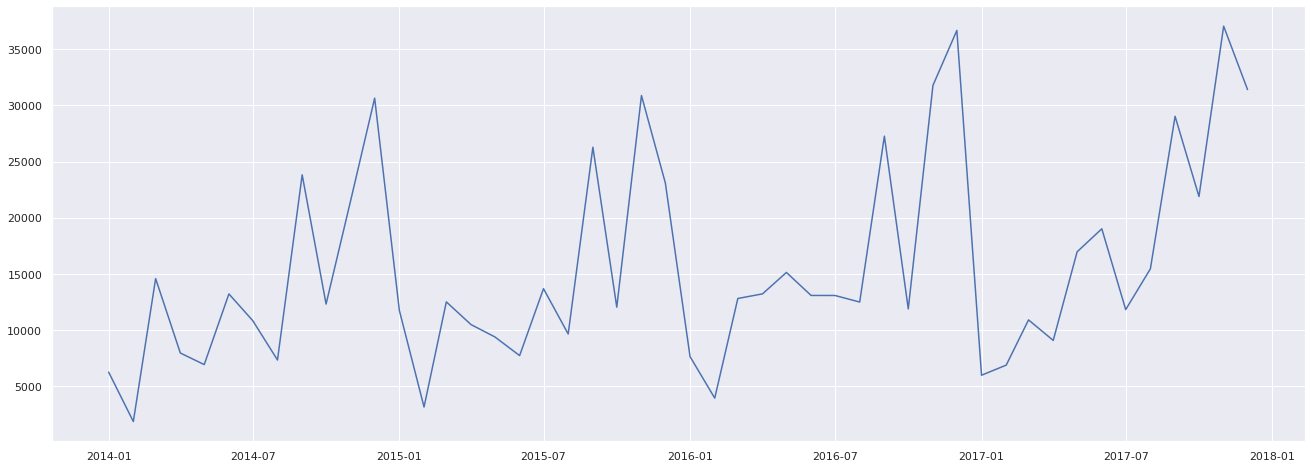

In [101]:
#Now we can visulize our cleaned dataset before modelling
plt.figure(figsize=(20,8))
plt.plot(furniture_msum)

<Figure size 1440x576 with 0 Axes>

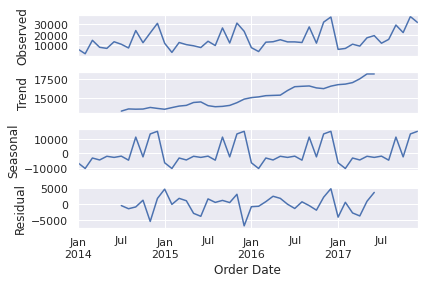

In [102]:
res = sm.tsa.seasonal_decompose(furniture_msum, model='additive')
plt.figure(figsize=(20, 8))
fig = res.plot()
fig.show()

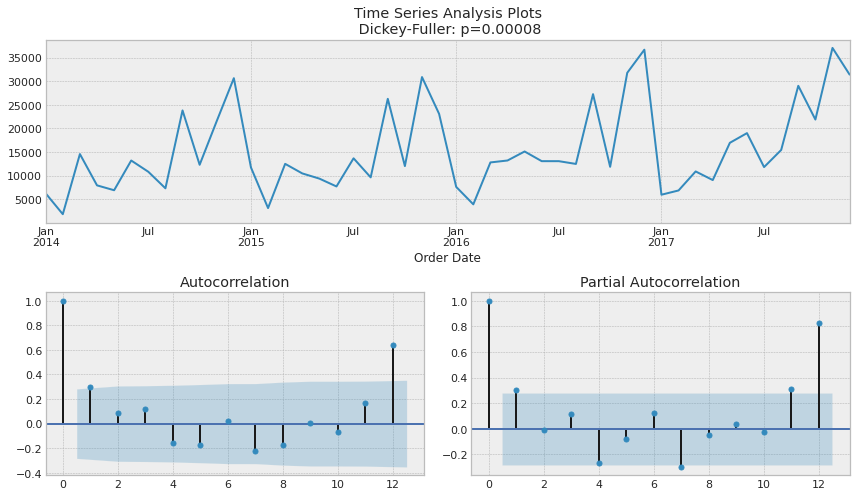

In [103]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(furniture_msum, lags=12)

**What data tells us, there is a strong seasonality, lower sales of furniture at the beginning months of a year and there is a upward trend of sales from jan to dec; However at the final months they likely to have more sales of furniture. Overall furniture sales is increasing over the years. From Dickey-Fuller test we have p is around zero, so we our data is stationary which is the one of the main condition for ARIMA. **

**Forecasting with ARIMA**

In [106]:
#Set initial values and some bounds
#Furthermore, this component requires the parameters P and Q which are the same as p and q, but for the seasonal component. 
#Finally, D is the order of seasonal integration representing the number of differences required to remove seasonality from the series.
ps = range(0, 2) #we look at the partial autocorrelation plot and identify the lag after which most lags are not significant.
d = 0 #The parameter d represents the number of differences required to make the series stationary.
qs = range(0, 2) #which represents the biggest lag after which other lags are not significant on the autocorrelation plot.
Ps = range(0, 2)
D = 0
Qs = range(0, 2)
s = 12 #s is simply the season’s length

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [107]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(furniture_msum, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

In [108]:
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(furniture_msum, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -479.197
Date:                            Sun, 30 Aug 2020   AIC                            968.393
Time:                                    14:46:30   BIC                            977.749
Sample:                                01-01-2014   HQIC                           971.929
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9884      0.027     36.511      0.000       0.935       1.042
ma.L1         -0.8897      0.132   

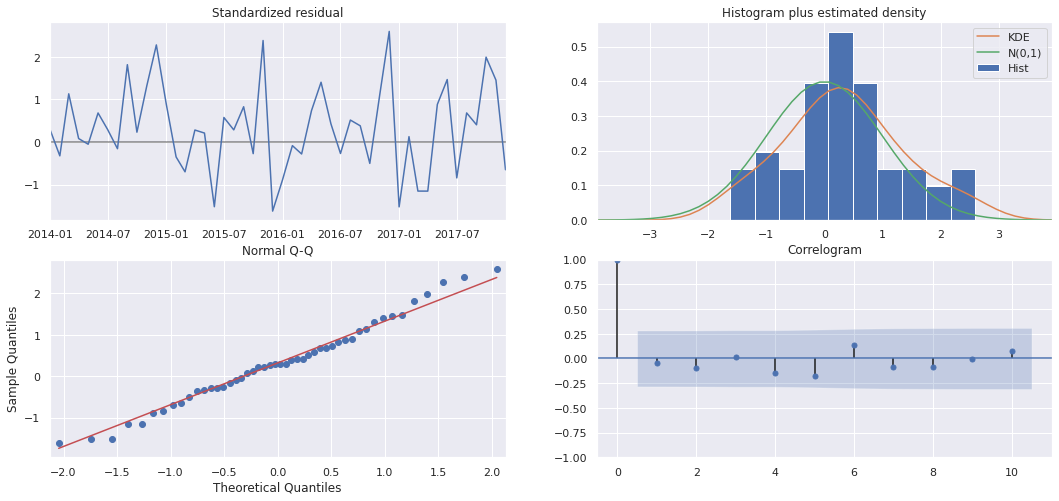

In [109]:
best_model.plot_diagnostics(figsize=(16, 8))
plt.show()

##Validating Forecasts
It seems not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed. Now To measure the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

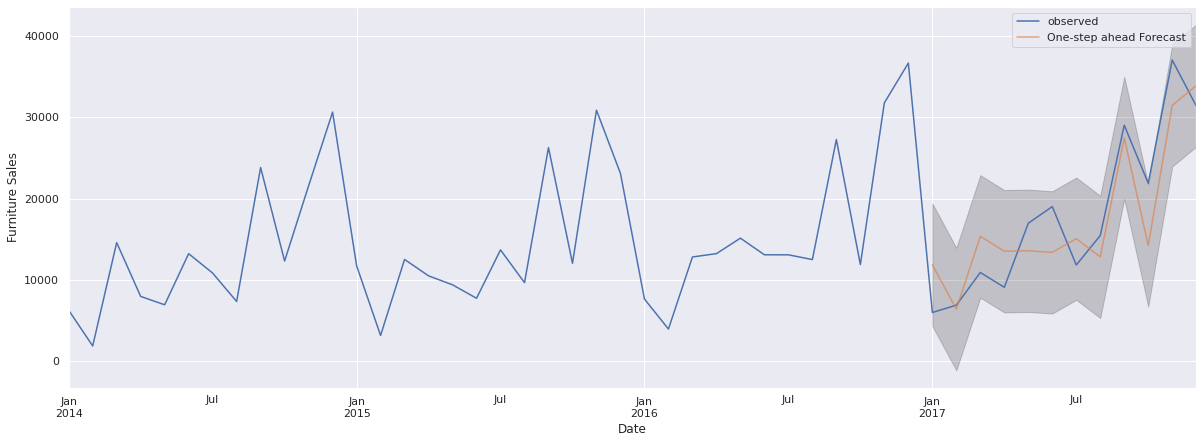

In [115]:
pred = best_model.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = furniture_msum['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [118]:
furniture_msum_forecasted = pred.predicted_mean
furniture_msum_truth = furniture_msum['2017-01-01':]
mse = ((furniture_msum_forecasted - furniture_msum_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 19461322.71


In [119]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 4411.5


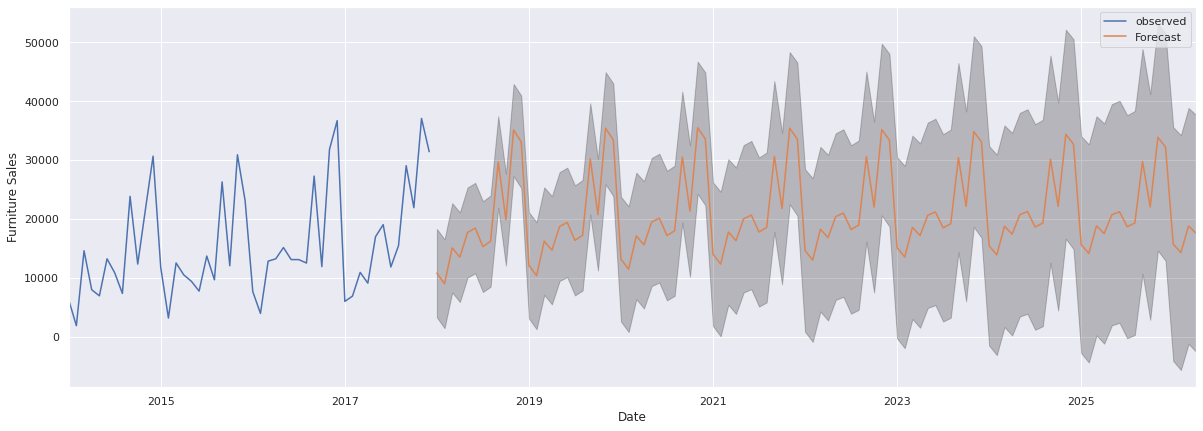

In [114]:
pred_uc = best_model.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = furniture_msum.plot(label='observed', figsize=(18, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

##Forecasting with Prophet

Prophet is released by Facebook as a forecasting tool. The authors of Prophet have abstracted away many of the inherent complexities of time series forecasting and made it more intuitive for analysts and developers alike to work with time series data.

In [ ]:
#pip install fbprophet

In [130]:
furniture_pmsum = furniture_msum.reset_index().rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_pmsum.head()

,ds,y
0,2014-01-01,6242.525
1,2014-02-01,1839.658
2,2014-03-01,14573.956
3,2014-04-01,7944.837
4,2014-05-01,6912.787


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1440x432 with 0 Axes>

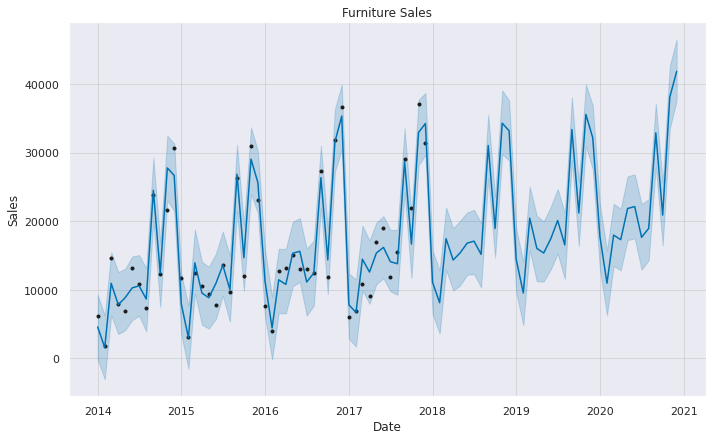

In [132]:
from fbprophet import Prophet
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture_pmsum)
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
plt.figure(figsize=(20, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');